### Try and use changes in spectrogram 2d array to predict strums and note changes

In [158]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pretty_midi
import librosa

In [159]:
input_cleaned_filename = "mp3_input/bass_NGHYB_clean.mp3"

seconds_start = 0
seconds_end = 10

x, sr = librosa.load(input_cleaned_filename)
x_custom_time = x[seconds_start * sr :seconds_end*sr]

In [160]:
strums = [0.491, 1.404, 2.282, 2.620, 2.876, 3.799, 4.618, 4.888, 5.275, 6.184, 7.084, 7.426, 7.715]
strums_light = [2.0165, 3.511, 4.420, 5.896, 6.767]

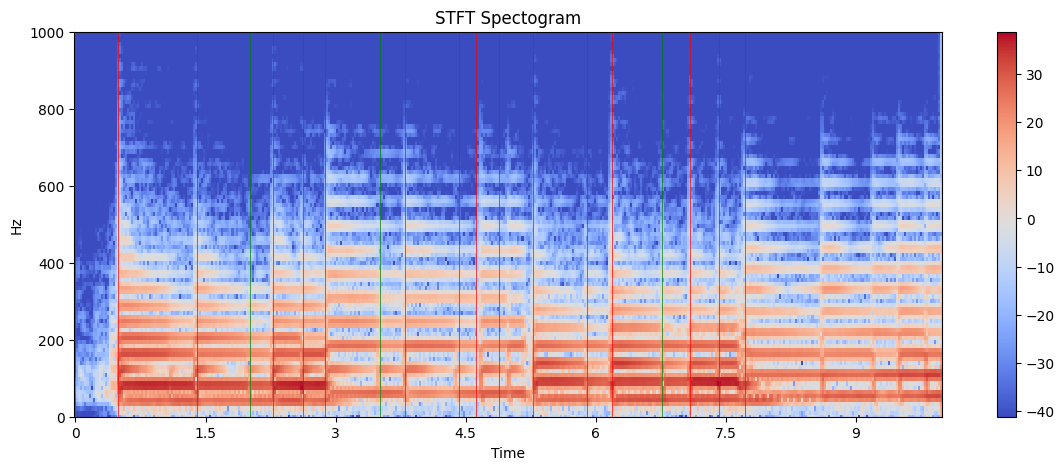

In [161]:
# x , sr = librosa.load(audio_path, sr = 22050) #loading the 11th file just for trial
X = librosa.stft(x_custom_time)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

for s in strums:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in strums_light:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

In [162]:
Xdb[20]

array([-41.189705  , -41.189705  , -41.189705  , -39.727547  ,
       -36.303104  , -30.95217   , -32.690872  , -30.661337  ,
       -27.63481   , -22.696957  , -24.073267  , -21.28129   ,
       -23.260756  , -34.03481   , -23.451555  , -32.07797   ,
       -21.32259   ,  -5.316327  ,  -0.37152025,   0.32103884,
        -3.523223  ,  15.835436  ,  20.598152  ,  23.68787   ,
        24.575912  ,  24.777332  ,  24.805122  ,  24.397121  ,
        24.62748   ,  24.178226  ,  24.209461  ,  24.300133  ,
        24.095526  ,  23.895248  ,  23.807705  ,  23.41555   ,
        23.311234  ,  23.007679  ,  22.716532  ,  22.461094  ,
        22.336695  ,  22.345888  ,  21.93907   ,  21.60389   ,
        21.624268  ,  21.099636  ,  20.34006   ,  19.503214  ,
        18.23988   ,  17.91293   ,  17.105381  ,  16.674318  ,
        15.803987  ,  15.677806  ,  15.531506  ,  14.809275  ,
        14.830728  ,  14.868168  ,  14.1227455 ,  15.3242    ,
        18.992392  ,  21.618593  ,  22.464588  ,  22.58

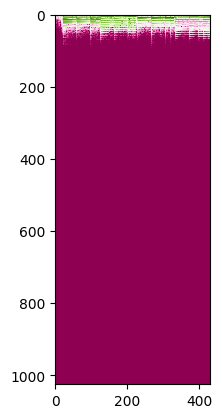

In [163]:
plt.imshow(Xdb, cmap='PiYG', interpolation='nearest')
plt.show()

In [164]:
Xdb_df = pd.DataFrame(Xdb)

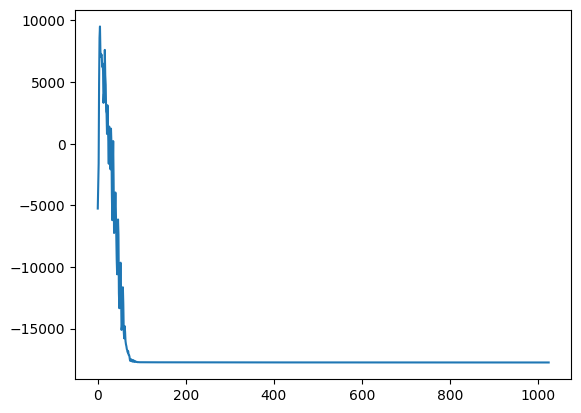

In [165]:
#use this to show how much of the lower rows are empty
row_sums = Xdb_df.sum(axis=1)
plt.plot(row_sums)

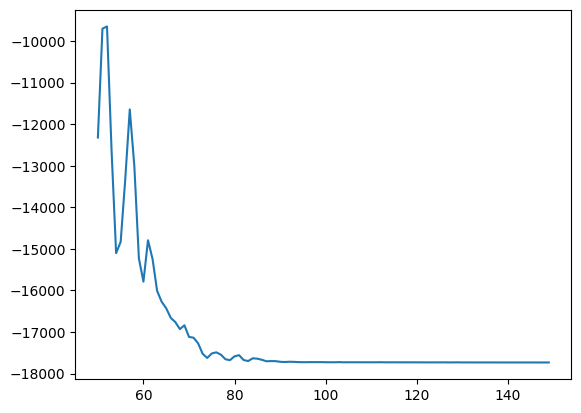

In [166]:
#look into where it plateaus 
plt.plot(row_sums[50:150])

In [167]:
#cutoff at index 70
[row_index for row_index in range(len(row_sums)) if row_sums[row_index] < -17000]


[70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241

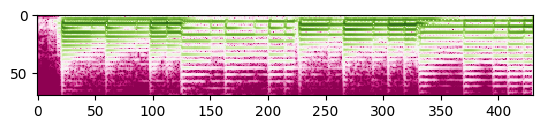

In [168]:
Xdb_condensed = Xdb[:70]

plt.imshow(Xdb_condensed, cmap='PiYG', interpolation='nearest')
plt.show()

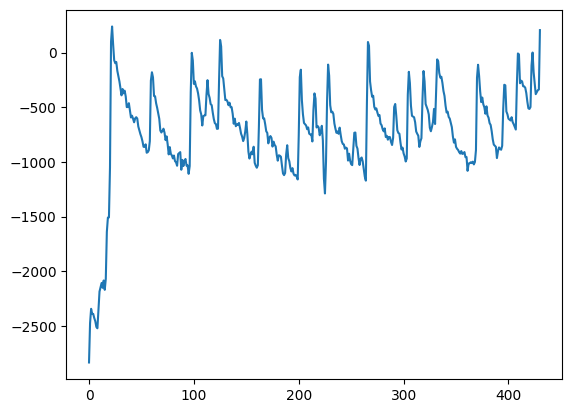

In [169]:
#column sums
col_sums = Xdb_condensed.sum(axis=0)
plt.plot(col_sums)

[0.0, 0.11740513890981674, 0.15970836579799652, 0.14481809735298157, 0.14453880488872528, 0.13223260641098022, 0.12271115183830261, 0.10579157620668411, 0.10180222243070602, 0.15658238530158997, 0.21106792986392975, 0.22320838272571564, 0.23660238087177277, 0.22215530276298523, 0.24396063387393951, 0.21621884405612946, 0.24915197491645813, 0.3887609541416168, 0.43118971586227417, 0.4317123293876648, 0.5803723335266113, 0.9543910622596741, 1.0, 0.9461755156517029, 0.8995472192764282, 0.8907928466796875, 0.8943066596984863, 0.867937445640564, 0.8513001799583435, 0.8363630175590515, 0.8158350586891174, 0.7950578331947327, 0.8139525651931763, 0.8010661602020264, 0.8089867830276489, 0.7918309569358826, 0.7599814534187317, 0.7603781223297119, 0.7717626690864563, 0.7501966953277588, 0.7291540503501892, 0.7344896793365479, 0.7255171537399292, 0.7148324251174927, 0.726379930973053, 0.730019211769104, 0.7260805368423462, 0.7023584842681885, 0.6905262470245361, 0.6795273423194885, 0.6705172061920

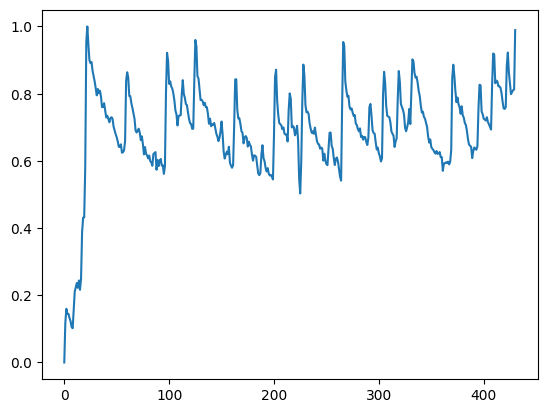

In [170]:
#standardize so that the same prominance can be used between songs 
col_sums_std = (col_sums - col_sums.min()) / (col_sums.max() - col_sums.min())
print(col_sums_std.tolist())
plt.plot(col_sums_std)

In [171]:
peaks_all, _ = find_peaks(col_sums_std, prominence=0.05)
peaks_strong, _ = find_peaks(col_sums_std, prominence=0.1)

peaks_weak = list(set(peaks_all) - set(peaks_strong))

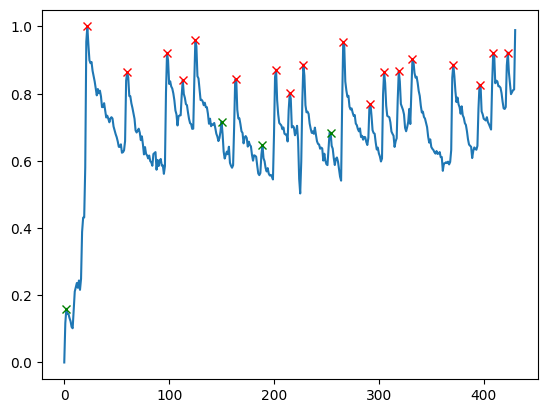

In [172]:
plt.plot(col_sums_std)
plt.plot(peaks_strong, col_sums_std[peaks_strong], "x", color = 'r')
plt.plot(peaks_weak, col_sums_std[peaks_weak], "x", color = 'g')

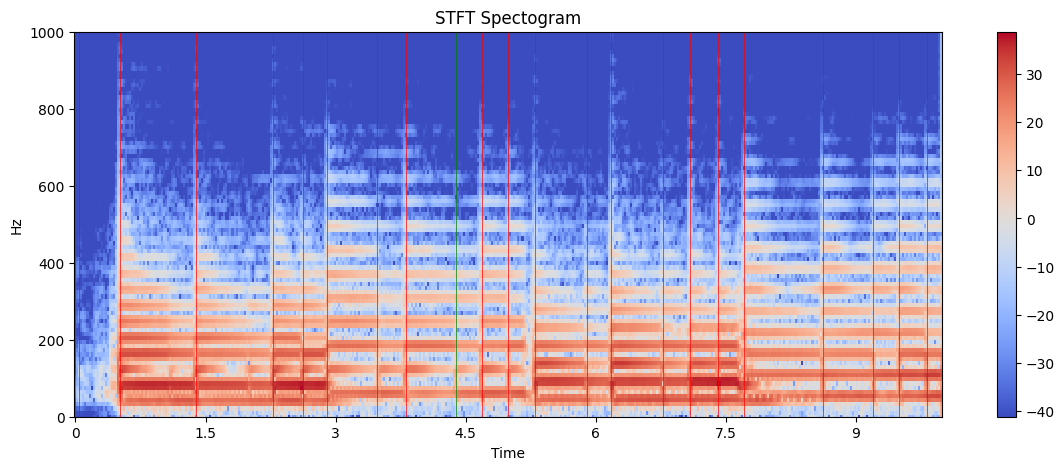

In [173]:
#turn indexes into times 
strums_strong_pred = librosa.frames_to_time(peaks_strong, sr=sr, hop_length=512)
strums_weak_pred = librosa.frames_to_time(peaks_weak, sr=sr, hop_length=512)

# x , sr = librosa.load(audio_path, sr = 22050) #loading the 11th file just for trial
X = librosa.stft(x_custom_time)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

for s in strums_strong_pred:
    plt.axvline(x=s, color='r', linewidth=0.5, linestyle="-")
for s in strums_weak_pred:
    plt.axvline(x=s, color='g', linewidth=0.5, linestyle="-")

In [180]:
#turn into 3d array 
#array of strums
#each strum represents freq vs time

Xdb_strums = np.split(Xdb, peaks_strong, axis = 1)

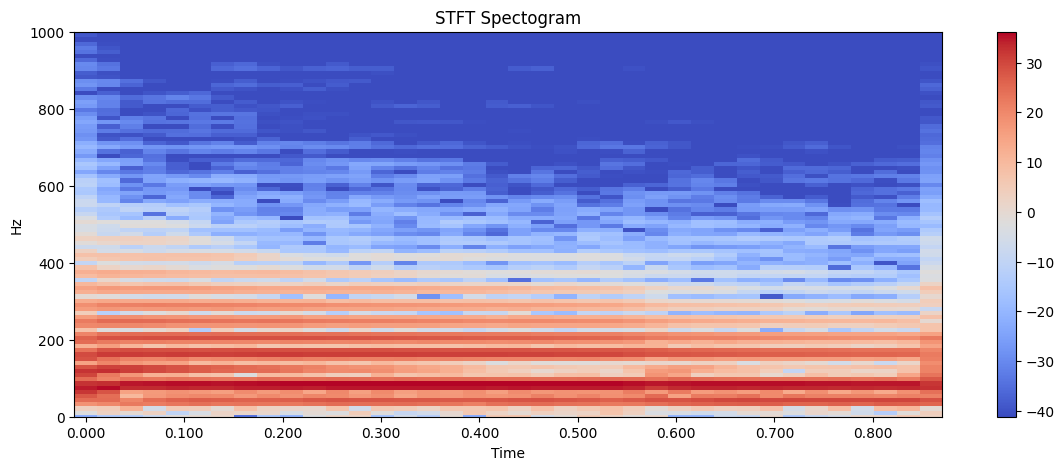

In [186]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_strums[1], sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()

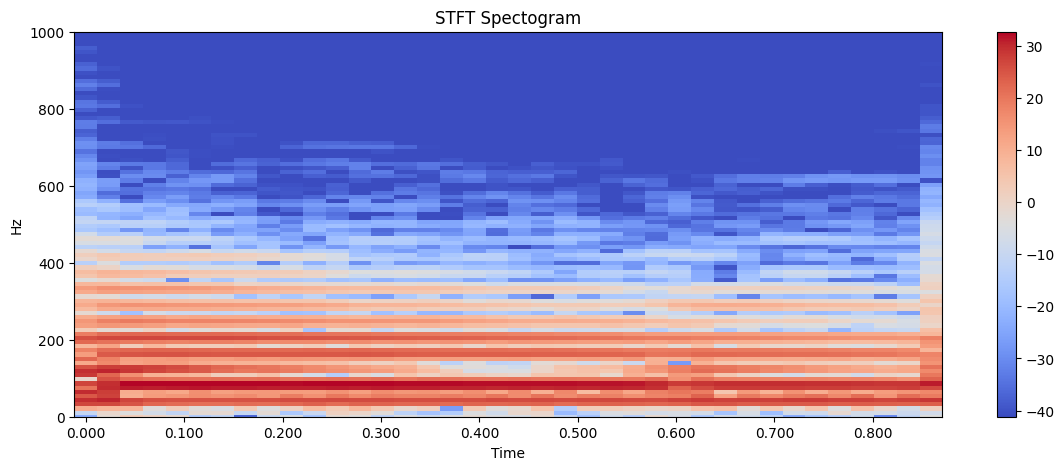

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_strums[2], sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 1000)
plt.title('STFT Spectogram')
plt.colorbar()